In [3]:
#####
#preliminary functions
#####

using Printf
using Plots
using LinearAlgebra
using Statistics
using SpecialFunctions

######
#WA mc routine

const L       = 10             # linear size of lattice
#the 4 different bond directions on the lattice
#index 1,2 is the direction in x,y 
#index 3 is the default link value in that direction
#link_default = [1,1,-1,-1]



#these arrays allow us to selct the x or y direction bonds
all_x = ones(Int32, 2*L, 2*L)
all_y = ones(Int32, 2*L, 2*L)

for i in 1:2:2*L
    all_x[:,i] = zeros(Int32, 2*L)
    all_y[i,:] = zeros(Int32, 2*L)
end

In [4]:
#######
#third attempts after Kun's insight
#######

dir_list = [[[1,0],1], [[0,1],1], [[-1,0],-1], [[0,-1,],-1]] 
#index 1,2 is the direction in x,y 
#index 3 is the default link value in that direction
#link_default = [1,1,-1,-1]



#these arrays allow us to selct the x or y direction bonds
all_x = ones(Int32, 2*L, 2*L)
all_y = ones(Int32, 2*L, 2*L)

for i in 1:2:2*L
    all_x[:,i] = zeros(Int32, 2*L)
    all_y[i,:] = zeros(Int32, 2*L)
end

function mod_latt_plus(site, direction_shift)
    val = ones(Int32, 2) + mod.(site - ones(Int32, 2) + direction_shift, 2*L)
    return val
end

#this function takes in a site M, the map of bonds and the "ratio"
#and return a new M based on the metropolis acceptance ratio
function move_worm(Ms, all_map, bessel_funcs)
    dir_link, prop_add = dir_list[rand(1:4)] #random link direction and change in bond value
                
    link_v = mod_latt_plus(Ms, dir_link)
    link_val = all_map[CartesianIndex(link_v[1], link_v[2])] #that's the current bond value
    new_val = link_val + prop_add #new bond value
    #deltaS = (ratio)*(new_val^2 - link_val^2) 


    #set the barrier height
    barrier = minimum([1, bessel_funcs[1 + abs(new_val)]/bessel_funcs[1 + abs(link_val)]])
    prob = rand()
    if (prob < barrier)
        #if you accept the move
        all_map[CartesianIndex(link_v[1], link_v[2])] = new_val
        Ms = mod_latt_plus(Ms, 2*dir_link)
        
        #the following lines were moved to the global function
        #dist_M_to_I += dir_link
        #gs_map = ones(Int32, 2) + mod.(dist_M_to_I, L)
        #g_map[CartesianIndex(gs_map[1], gs_map[2])] += 1
    else
        dir_link = [0,0]
    end
    
    return Ms, dir_link, all_map
end



function sweep_v4(nv, bessel_funcs, all_map, kappa)     
    w_list = []
    accum_w_list = [0.0] #this keeps the accumulated winding number in memory
    accum_winding = 0 #this accumulates the winding number
    
    g_map = zeros(Int32, L, L)
    
    i = 0
        
    Is = [2*rand(1:L), 2*rand(1:L)]
    Ms = Is
    dist_M_to_I = [0,0]
    Z_count = 1
    had_worm = 0
    in_Z_sector = true
    #these conditions set parameters such that the first thing done is to start a worm
    
    while i <= nv
        
        q_c = rand()
        
        if in_Z_sector
            #hey, you're in the Z-sector
            #choose an I=M
            #if q_c < kappa, you then become in the G sector
            #this is the start of a worm
            if q_c < kappa
                #create_worm
                Is = [2*rand(1:L), 2*rand(1:L)]
                Ms = Is
                in_Z_sector = false
                had_worm = 0
            end
            
            #since you were just in the Z sector, with closed worms
            #then measure the winding number
            winding = 0.5*((dist_M_to_I[1]/L)^2 + (dist_M_to_I[2]/L)^2)
            #display(winding)
            accum_winding += winding
            accum_winding_norm = accum_winding/length(accum_w_list)
            #add the accumulated winding to a running average list
            push!(accum_w_list, accum_winding_norm) 
            
        else
            #hey, you actually were not in the Z sector
            #but rather in the G sector - you need to move the worm
            #move a worm
            Ms, dir_link, all_map = move_worm(Ms, all_map, bessel_funcs)
            dist_M_to_I += dir_link
            if dir_link != [0,0]
                gs_map = ones(Int32, 2) + mod.(dist_M_to_I, L)
                g_map[CartesianIndex(gs_map[1], gs_map[2])] += 1
                had_worm = 1
            end 
            
            #did you end up on I=M?
            #if so, ask whether you'd like to return to the Z sector
            #this is also wher you count the number of times you returned to the Z sector after creating a worm of a finite length
            
            if Is == Ms
                if q_c < 1/kappa
                    #annihilate_worm
                    in_Z_sector = true
                    Z_count += 1*(had_worm) #do not count Z configs if you did not update the worm
                end
            end
        end
        
        #counter
        i += 1
        
    end
        
    return Z_count, accum_w_list, g_map
end



sweep_v4 (generic function with 1 method)

In [5]:
####
#mc routine for a single temperature
####
T = 0.1
β = 1/T
ratio = 1/(2*β)
@printf "Temperature %.2f" T
@printf "\n"

all_map = zeros(Int32,2*L, 2*L) 

#first, thermalize
#v1, v2, v3 = sweep_v3(200, ratio, all_map, 1.0)
bessel_funcs = [besseli(n, β) for n in 0:30]

sweep_v4((10^3)*L^2, bessel_funcs, all_map, 1.0)
Z_count, accum_w_list, g_map_vals = sweep_v4((10^4)*L^2, bessel_funcs, all_map, 1.0)

w_length = length(accum_w_list)
#w_t = T*mean(accum_w_list[Int(w_length/3):end])
final_w = accum_w_list[floor(Int, 2*w_length/3):end]*T
w_t = final_w[end]
w_t_std = (maximum(final_w) - minimum(final_w))/2
@printf "Stiffness %.3f ± %.3f" w_t w_t_std
@printf "\n"
energy = -(g_map_vals[1,2] + g_map_vals[2,1] + g_map_vals[1,L] + g_map_vals[L,1])/(2*Z_count)
@printf "Energy %.2f" energy


Temperature 0.10
Stiffness 1.484 ± 0.064
Energy -1.99

In [6]:
temps   = 3.2:-0.3:0.2  # temperatures to sample
nt = length(temps)      #number of temperatures

stiff_val = []
stiff_err = []
all_map = zeros(Int32,2*L, 2*L) 

for T in temps
    β = 1/T
    ratio = 1/(2*β)
    
    bessel_funcs = [besseli(n, β) for n in 0:30]

    sweep_v4((10^4)*L^2, bessel_funcs, all_map, 1.0)
    Z_count, accum_w_list, g_map_vals = sweep_v4((10^4)*L^2, bessel_funcs, all_map, 1.0)

    w_length = length(accum_w_list)
    final_w = accum_w_list[floor(Int, 2*w_length/3):end]*T
    w_t = final_w[end]
    w_t_std = (maximum(final_w) - minimum(final_w))/2
    
    push!(stiff_val, w_t)
    push!(stiff_err, w_t_std)
    
    @printf "Done T=%.1f" T
    @printf "\n"
    flush(stdout)
end    

Done T=3.2
Done T=2.9
Done T=2.6
Done T=2.3
Done T=2.0
Done T=1.7
Done T=1.4
Done T=1.1
Done T=0.8
Done T=0.5
Done T=0.2


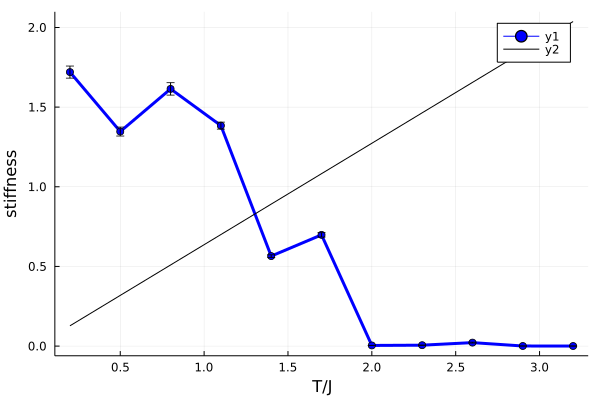

In [7]:
plot(temps, stiff_val, yerr = stiff_err, lw = 3, shape = :circle, color = :blue, markersize = 4)
plot!(temps, 2*temps/pi, lw = 1, color = :black)
xlabel!("T/J")
ylabel!("stiffness")